## PI-3 Running SFINCS using the National Water Model 3.0 inputs

Below is a notebook for running SFINCS using National Water Model inputs over a domain of interest

Author: Tadd Bindas

### Step 0: Import dependencies and create national water model data

In [96]:
from pathlib import Path

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx
import zarr

import hydromt
from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils
from hydromt_sfincs import workflows

### Step 1: Define the model:

First, we need to create a SFINCS Model object and some Data Catalogs to point at external data. The SFINCS object saves internal states and a config for mapping to external files

In [52]:
root = Path("/app/data/SFINCS/ngwpc_data/")

yml_str = f"""
meta:
  root: {root.__str__()}
  
10m_lidar:
  path: HUC6_110701_dem.tif
  data_type: RasterDataset
  driver: raster
  driver_kwargs:
    chunks:
      x: 6000
      y: 6000
  meta:
    category: topography
    crs: 5070
  rename:
    10m_lidar: elevtn
"""
data_lib = Path(
    "/app/data/SFINCS/data_catalogs/10m_huc6_lidar.yml"
)
if data_lib.exists() is False:
    with open(data_lib, mode="w") as f:
        f.write(yml_str)

In [53]:
data_catalog = hydromt.DataCatalog(data_libs=[data_lib])
sf = SfincsModel(data_libs=[data_lib], root="/app/data/SFINCS/ngwpc_data", mode="w+")

### Step 2: Set up the bounding boxes around the catchments of interest

Since we want to determine the flooding downstream of the current RFC station, we have to subset our graph to determine where these catchments exist

In [54]:
import sys

current_dir = Path.cwd()
src_path = current_dir.parents[0]
sys.path.append(src_path.__str__())

from src.rise.utils import hydrofabric  # noqa: E402

In [5]:
# Hardcoded HUC8
huc_8 = "11070103"
base_data_path = Path("/app/data/NWM")
output_geojson = base_data_path / f"output_{huc_8}.geojson"
huc8_data = base_data_path / "huc8s_sp.gpkg"
gdf = gpd.read_file(huc8_data)
subset  = gdf[gdf["HUC8"] == huc_8]
subset.to_file(output_geojson, driver='GeoJSON')

In [6]:
file_path = Path("/app/data/NWM/nextgen_11.gpkg")

flowlines = hydrofabric.get_layer(file_path, layer="flowpaths")
nexus = hydrofabric.get_layer(file_path, layer="nexus")
divides = hydrofabric.get_layer(file_path, layer="divides")
flowpath_attributes = hydrofabric.get_layer(file_path, layer="flowpath_attributes")

G = hydrofabric.get_hydrofabric_vpu_graph(nexus, flowlines)

In [7]:
# Hardcoded start and end nodes
start_node = "nex-2177032"
end_node = "nex-2175887"
path = nx.shortest_path(G, start_node, end_node)
path

['nex-2177032',
 'wb-2177032',
 'nex-2175879',
 'wb-2175879',
 'nex-2175880',
 'wb-2175880',
 'nex-2175881',
 'wb-2175881',
 'nex-2175882',
 'wb-2175882',
 'nex-2175883',
 'wb-2175883',
 'nex-2175884',
 'wb-2175884',
 'nex-2175885',
 'wb-2175885',
 'nex-2175886',
 'wb-2175886',
 'nex-2175887']

In [8]:
mask_flowlines = flowlines["id"].isin(path) | flowlines["toid"].isin(path)
mask_nexus = nexus["id"].isin(path)
mask_divides = divides["id"].isin(path)
# mask_attributes = flowpath_attributes["id"].isin(path)

_subset_nexus = nexus[mask_nexus]
_subset_flowlines = flowlines[mask_flowlines]
_subset_divides = divides[mask_divides]

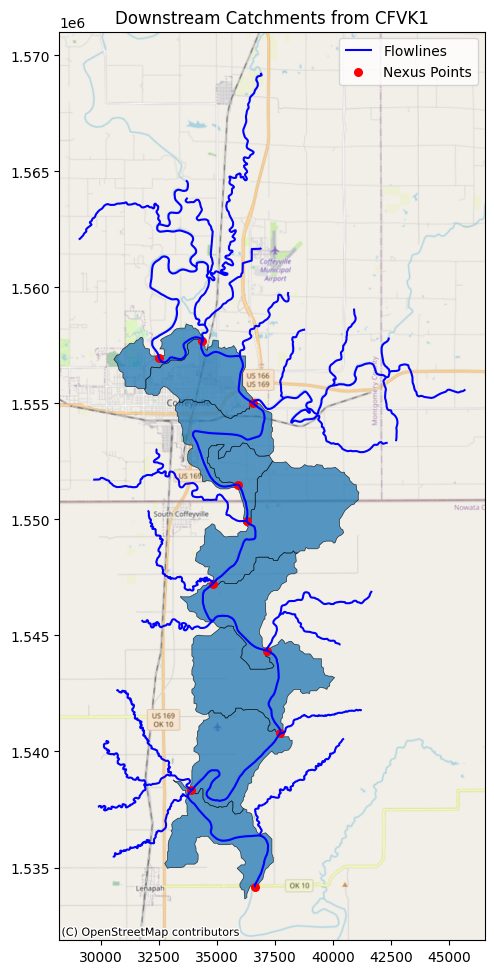

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
_subset_divides.plot(ax=ax, edgecolor="k", linewidth=0.5, alpha=0.75,)
_subset_flowlines.plot(ax=ax, color='blue', label='Flowlines')
_subset_nexus.plot(ax=ax, color='red', markersize=30, label='Nexus Points')
try:
    cx.add_basemap(ax, crs=_subset_divides.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
except Exception as e:
    print(f"Couldn't add basemap: {e}")
ax.legend()
plt.title("Downstream Catchments from CFVK1")
plt.tight_layout()
plt.show()

In [55]:
merged_polygon = unary_union(_subset_divides['geometry'])
merged_gdf = gpd.GeoDataFrame(geometry=[merged_polygon], crs=gdf.crs)
output_divides = "/app/data/NWM/flowlines_divides.geojson"
merged_gdf.to_file(output_divides, driver='GeoJSON')

In [56]:
sf.setup_grid_from_region(
    region = {'geom': '/app/data/NWM/flowlines_divides.geojson'},
    res= 50,
    rotated=True,
    crs=_subset_divides.crs  # NAD83 / Conus Albers HARDCODED TODO figure out making this cleaner
)
# the input file is automatically updated. Uncomment to displayed below:
print(sf.config)

{'mmax': 199, 'nmax': 499, 'dx': 50, 'dy': 50, 'x0': 32932.0, 'y0': 1533316.0, 'rotation': 5.758, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 1, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070}


### Step 3: Load in Elevation Data

We're going to be loading in elevation data from FIM-C

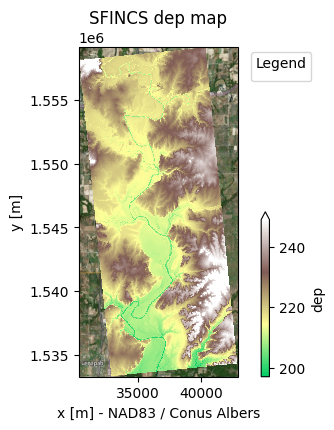

In [57]:
datasets_dep = [{"elevtn": "10m_lidar", "zmin": 0.001}]

dep = sf.setup_dep(datasets_dep=datasets_dep)

_ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)

### Step 4: Mask active cells, boundaries, and coasts

We're going to be masking all active cells as cells above -5 meters. This will properly define coastal vs non-coastal boundaries

In [58]:
outflow_polygon = _subset_divides[_subset_divides["id"] == "wb-2175886"]
outflow_polygon.head()
# outflow_polygon.to_file("/app/data/NWM/outflow_polygon.geojson", driver='GeoJSON')

,divide_id,toid,type,ds_id,areasqkm,id,lengthkm,tot_drainage_areasqkm,has_flowline,geometry
12625,cat-2175886,nex-2175887,network,NaN,9.44325,wb-2175886,7.030249,9281.407675,True,"POLYGON ((36045 1535415, 36015 1535655, 35955 ..."


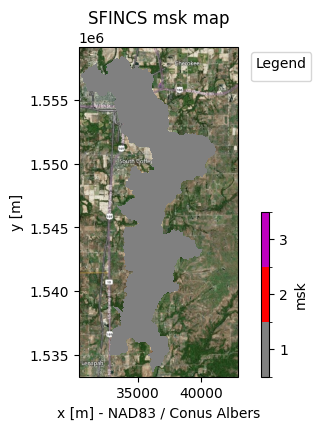

In [61]:
sf.setup_mask_active(include_mask=merged_gdf,reset_mask=True)

_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

### Step 5: Add output boundaries

We're going to now mask the boundaries of catchments/rivers

<GeoAxes: title={'center': 'SFINCS msk map'}, xlabel='x [m] - NAD83 / Conus Albers', ylabel='y [m]'>

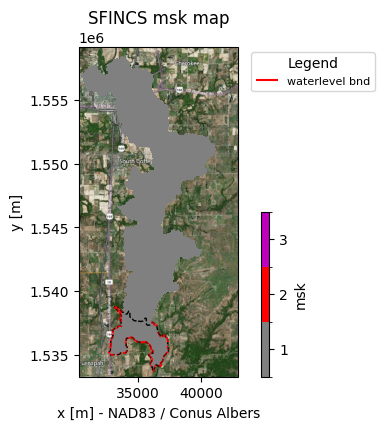

In [62]:
sf.setup_mask_bounds(btype="waterlevel", include_mask=outflow_polygon, reset_bounds=True)

# Here we add outflow cells, only where clicked in shapefile along part of the lateral boundaries
# sf.setup_mask_bounds(btype="outflow", include_mask=outflow_polygon, reset_bounds=True)

# Make a plot of the mask file
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)
outflow_polygon.to_crs(sf.crs).boundary.plot(
    ax=ax, color="k", lw=1, ls="--"
)  # plot the shapefile given by the user as dashed line

### Step 6: Add river inflow data

Using the hydrofabric we can add flowlines to show where rivers are located within the Hydrofabric

{'mmax': 199, 'nmax': 499, 'dx': 50, 'dy': 50, 'x0': 32932.0, 'y0': 1533316.0, 'rotation': 5.758, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 1, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070, 'depfile': 'sfincs.dep', 'mskfile': 'sfincs.msk', 'indexfile': 'sfincs.ind'}


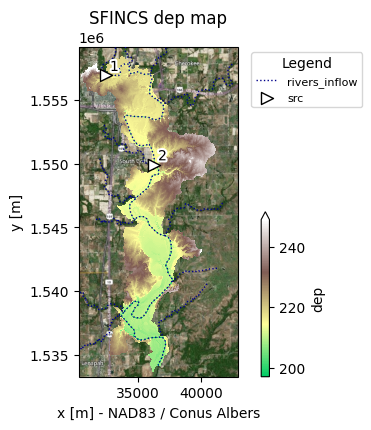

In [63]:
sf.setup_river_inflow(
    rivers=_subset_flowlines, keep_rivers_geom=True
)
print(sf.config)
# Make a plot of model
# note the src points and derived river network
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat", zoomlevel=12)

In [64]:
gdf_riv = sf.geoms["rivers_inflow"].copy()
df_reordered = pd.merge(gdf_riv["id"], flowpath_attributes, on='id', how='left')
gdf_riv["rivwth"] = np.mean(df_reordered["TopWdth"].values) # width [m]

# Assuming depth is 1.5m, TODO come back later
gdf_riv["rivdph"] = 1.5  # depth [m]
gdf_riv["manning"] = df_reordered["n"].tolist()  # manning coefficient [s.m-1/3]
gdf_riv[["geometry", "rivwth", "manning"]]

datasets_riv = [{"centerlines": gdf_riv}]

### Step 7: Add spatially varying roughness

Our roughness data needs to be spatially varying, and can use the flowpath attributes in the hydrofabric

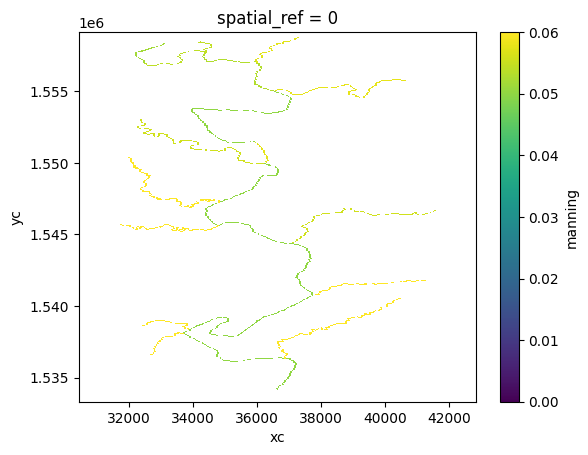

In [65]:
gdf_riv_buf = gdf_riv.assign(geometry=gdf_riv.geometry.buffer(0.2))
# da_manning = sf.grid.raster.rasterize(gdf_riv_buf, "manning", nodata=np.nan)
da_manning = sf.grid.raster.rasterize(gdf_riv, "manning", nodata=np.nan)

# use the river manning raster in combination with vito land to derive the manning roughness file
# NOTE that we can combine in-memory data with data from the data catalog
datasets_rgh = [{"manning": da_manning}]

# uncomment to plot either the raster or the vector data:
da_manning.plot(vmin=0, x='xc', y='yc', cmap='viridis')

### Step 8: Make subgrid derived tables:
Subgrid derived tables are used to better capture the elevation and roughness of your domain, to either improve your results, or to allow you to run on a courser grid resolution (means faster simulation). For more info about subgrid tables, [click here](https://sfincs.readthedocs.io/en/latest/developments.html#recent-advancements-in-accuracy-subgrid-mode). 

You as user can specify multiple settings about how the subgrid derived tables should be made.

Every single grid cell of the flux grid of the size inp.dx by inp.dy is defined into subgrid pixels (default nr_subgrid_pixels = 20).
For every subgrid pixel the topobathy data is loaded, ideally this consists of high-resolution DEM datasets that you specify as user.

In this example with dx=dy=50m, having nr_subgrid_pixels = 20 means we are loading data onto a 2.5 m subpixel grid
However, the input data of Gebco and Merit_hydro is way coarser, therefore let's set the ratio to 5 for now.

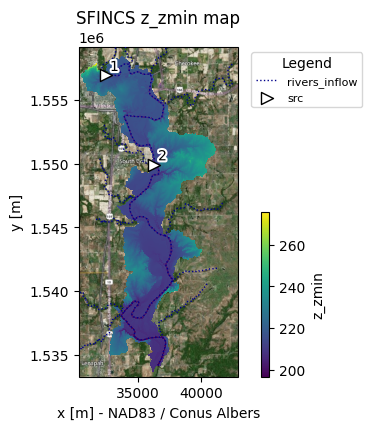

In [66]:
# ignoring for now
sf.setup_subgrid(
    datasets_rgh=datasets_rgh,
    datasets_dep=datasets_dep,
    datasets_riv=datasets_riv,
    nr_subgrid_pixels=5,
    write_dep_tif=False,
    write_man_tif=False,
)
_ = sf.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, bmap="sat", zoomlevel=12
)

### Step 9: Add an upstream discharge time-series as forcing (NWM retrospective)

We're going to be pulling inputs from the national water model retrospective using TEEHR

In [67]:
conus_df = pd.read_parquet("/app/data/NWM/conus_net.parquet")
_df = conus_df[conus_df["id"].isin(_subset_flowlines["id"].values)]
_feature_ids = _df[~np.isnan(_df["hf_id"])]
feature_ids = _feature_ids["hf_id"].values.astype(int)
mapping = {}
for _hf_id, _id in zip(_feature_ids["hf_id"], _feature_ids["id"]):
    _mapped_features = mapping.get(_id, None)
    if _mapped_features is None:
        mapping[_id] = [_hf_id]
    else:
        mapping[_id].append(_hf_id)

In [68]:
from teehr.loading.nwm import retrospective_points as nwm_retro
from datetime import datetime
# Define the parameters.
NWM_VERSION = "nwm30"
VARIABLE_NAME = "streamflow"
START_DATE = datetime(2019, 5, 20)
END_DATE = datetime(2019, 5, 28)
LOCATION_IDS = feature_ids

OUTPUT_ROOT = Path("/app/data/NWM/")
OUTPUT_DIR = Path(OUTPUT_ROOT, "nwm30_retrospective")

In [69]:
# Fetch and load the data.
nwm_retro.nwm_retro_to_parquet(
    nwm_version=NWM_VERSION,
    variable_name=VARIABLE_NAME,
    start_date=START_DATE,
    end_date=END_DATE,
    location_ids=LOCATION_IDS,
    output_parquet_dir=OUTPUT_DIR
)

In [70]:
flow_data = pd.read_parquet(OUTPUT_DIR / "20190520_20190528.parquet")
flow_data[['nwm_version', 'location_id']] = flow_data['location_id'].str.split('-', expand=True)

In [71]:
root = zarr.open_group(path="/app/data/NWM/nwm30_retrospective.zarr", mode="w")
flood_root = root.require_group("coffeyville.zarr")
flood_root.array(
    name="value_time",
    data=np.array(flow_data["value_time"].unique()),
    dtype="datetime64[ns]"
)

<zarr.core.Array '/app/data/NWM/nwm30_retrospective.zarr/coffeyville.zarr/value_time' (216,) datetime64[ns]>

In [72]:
for k, v in mapping.items():
    v = np.array([str(int(_v)) for _v in v])
    flow = flow_data[flow_data["location_id"].isin(v)].groupby("value_time")["value"].mean().reset_index()["value"].values
    flood_root.array(
        name=k,
        data=flow,
    )  

Determine source point catchment ID numbers for properly assigning inflow

In [73]:
gdf_src = workflows.flwdir.river_source_points(
    gdf_riv=_subset_flowlines,
    gdf_mask=sf.region,
    src_type="inflow",
    buffer=200,
    river_upa=10.0,
    river_len=1e3,
    da_uparea=None,
    reverse_river_geom=False,
    logger=sf.logger,
)

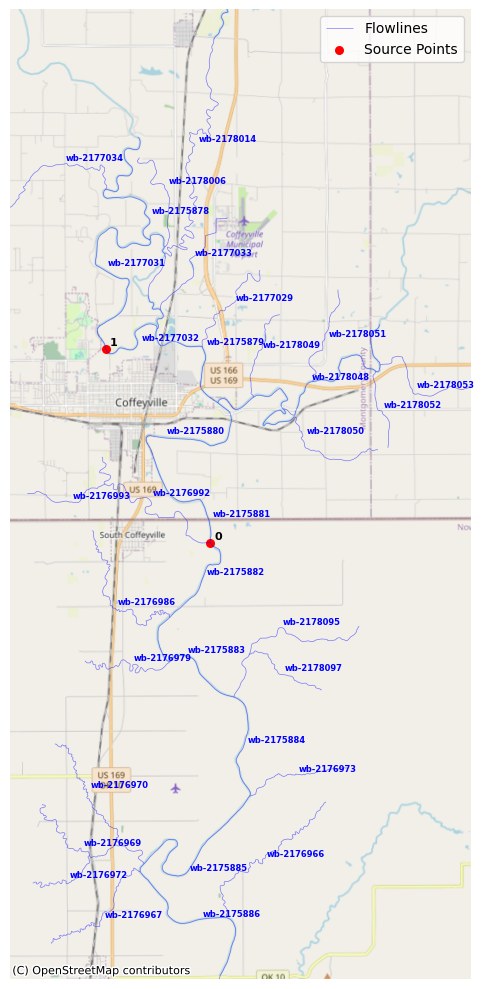

In [74]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot flowlines
_subset_flowlines.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.5, label='Flowlines')

for idx, row in _subset_flowlines.iterrows():
    # Get the midpoint of the line for label placement
    midpoint = row.geometry.interpolate(0.5, normalized=True)
    ax.annotate(str(row['id']), (midpoint.x, midpoint.y), 
                xytext=(3, 3), textcoords="offset points",
                fontsize=6, color='blue', fontweight='bold')

# Add labels to each point
for idx, row in gdf_src.iterrows():
    ax.annotate(str(idx), (row.geometry.x, row.geometry.y), 
                xytext=(3, 3), textcoords="offset points",
                fontsize=8, color='black', fontweight='bold')

# Plot source points
gdf_src.plot(ax=ax, color='red', markersize=30, label='Source Points')


# Add basemap (optional, requires internet connection)
try:
    cx.add_basemap(ax, crs=gdf_src.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
except Exception as e:
    print(f"Couldn't add basemap: {e}")

# Customize the plot
ax.legend()
ax.set_axis_off()

# Adjust the plot extent to show all geometries
bounds = gdf_src.total_bounds.tolist()
bounds = [
    min(bounds[0], _subset_flowlines.total_bounds[0]),
    min(bounds[1], _subset_flowlines.total_bounds[1]),
    max(bounds[2], _subset_flowlines.total_bounds[2]),
    max(bounds[3], _subset_flowlines.total_bounds[3])
]
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

plt.tight_layout()
plt.show()

In [80]:
# manually mapping flows to correct subset
mapping_flows_order = np.array([1, 0])
# mapping_flows_order = np.array([5, 6, 0, 1, 2, 3, 4, 9, 10, 11, 7, 8])

In [87]:
buffered_lines = _subset_flowlines.copy()
buffered_lines['geometry'] = _subset_flowlines.geometry.buffer(50)
intersection = gpd.overlay(gdf_src, buffered_lines, how='intersection')
_subset_intersection = intersection[intersection["id"].isin(["wb-2177031", "wb-2176992"])]

In [88]:
sf.setup_config(
    **{
        "tref": "20190520 000000",
        "tstart": "20190520 000000",
        "tstop": "20190527 000000",
    }
)

In [91]:
time = pd.date_range(
    start=utils.parse_datetime(sf.config["tstart"]),
    end=utils.parse_datetime(sf.config["tstop"]),
    periods=8,
)
dis = []
for _id in _subset_intersection["id"]:
    dis.append(flood_root[_id][::24][:-1])
dis = np.array(dis)[mapping_flows_order].T

index = sf.forcing["dis"].index
dispd = pd.DataFrame(index=time, columns=index, data=dis)
# # now we call the function setup_discharge_forcing, which adds the discharge forcing to the src points
sf.setup_discharge_forcing(timeseries=dispd)

# # # NOTE: the discharge forcing data is now stored in the sf.forcing dictionary
sf.forcing.keys()

dict_keys(['dis'])

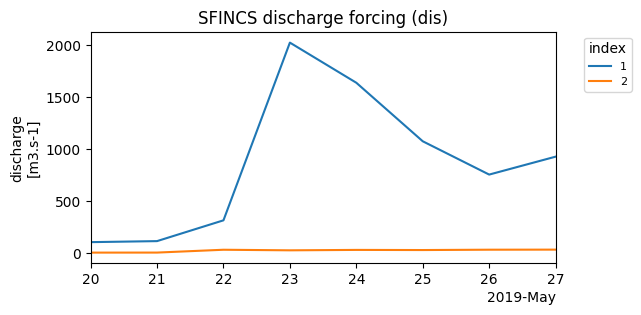

In [92]:
_ = sf.plot_forcing(fn_out="forcing.png")

### Step 10: Add weirfile:
In SFINCS, a weirfile is often used to explicity account for line-element features such as dikes, dunes or floodwalls. Read more about structures in the [SFINCS manual](https://sfincs.readthedocs.io/en/latest/input_structures.html)

In [93]:
weir_gdf = gpd.read_file("/app/data/NWM/nld_subset_levees.gpkg")
weir_gdf.to_file("/app/data/NWM/nld_subset_levees.geojson", driver='GeoJSON')
# In this example specify a 'line' style shapefile for the location of the weir to be added
# NOTE: optional: dz argument - If provided, for weir structures the z value is calculated from the model elevation (dep) plus dz.
sf.setup_structures(
    structures="/app/data/NWM/nld_subset_levees.geojson",
    stype="weir",
    dz=None,
)

# NOTE: the observation points are now stored in the sf.geoms dictionary
sf.geoms.keys()

dict_keys(['region', 'rivers_inflow', 'weir'])

### Step 11: Show and write model settings to disk

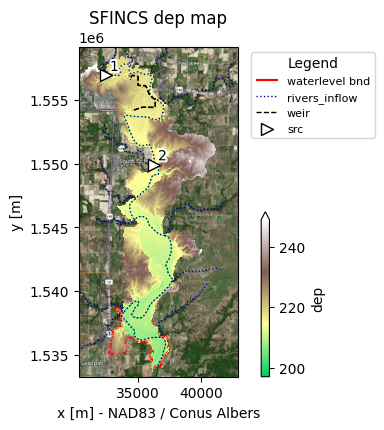

In [94]:
# Use predefined plotting function 'plot_basemap' to show your full SFINCS model setup
_ = sf.plot_basemap(fn_out="basemap.png", bmap="sat", zoomlevel=12)

In [95]:
sf.write()  # write all
dir_list = os.listdir(sf.root)
print(dir_list)

['hydromt_data.yml', 'sfincs_subgrid.nc', 'sfincs.dis', 'sfincs.src', 'sfincs_map.nc', '.ipynb_checkpoints', '10m_huc6_lidar.yml', 'figs', 'sfincs.dep', 'gis', 'sfincs.inp', 'HUC6_110701_dem.tiff', 'sfincs.weir', 'hydromt.log', '.gitkeep', 'sfincs.ind', 'sfincs.msk']


Now, we can proceed to the `run_sfincs_from_nwm.ipynb` to run and visualize this flood model!